# Simulation: perfect controller

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/dm4bem_book/HEAD?labpath=%2Ftutorials%2F02_2_4Toy.ipynb)

The simulation is done by [numerical integration](https://en.m.wikipedia.org/wiki/Numerical_integration) of the [state-space](https://en.m.wikipedia.org/wiki/State-space_representation) representation by using the description of the model as a thermal circuit, the input data set, and the weather data.

**Objectives:**
- Resample the inputs at time step.
- Create input vector in time.
- Integrate in time the state-space model.
- Plot the results.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctrl
import time

import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf

![thermal_circuit](../figures/03_therm_circ.svg)
> Figure 1. Thermal circuit for the cubic building.

The following assumptions can be done (see Figure 1):
- The indoor air temperature is not controlled (i.e., the building is in free running) or it is controlled by a P-controller having the gain $K_p = G_{11}.$
- The capacities of the air, $C_6$, and of the glass, $C_7$, can be neglected or not.
- The time integration is done by using Euler explicit or Euler implicit.
- The time step is calculated from the eigenvalues of the state matrix or it is imposed at a value designated as $\Delta t$.

In [46]:
controller = True
Kp = 1e3    # W/°C, controller gain

explicit_Euler = True

imposed_time_step = True
Δt = 360    # s, imposed time step

## State-space representation

The thermal circuit was described in the section on modelling. It is read from the file `./toy_model/TC.csv`. Thermal circuit is transformed in state-space representation.

In [47]:
# MODEL
# =====
# Thermal circuits
## Building properties
l = 4                     # m length 
L = 5                     # m length 
height = 3                    # m height of the walls
Sw = 1.30**2       # m² surface area of one window
Sd =  1* 1          # m² surface area of the door
Sc = Si =  6 * l * L - 2*Sw - Sd   # m² surface area of concrete & insulation of the walls

## Thermophysical properties

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc}                  # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Sc}                # m²

glass = {'Conductivity': 2.8,               # W/(m²·K) - https://www.gov.scot/binaries/content/documents/govscot/publications/advice-and-guidance/2020/02/tables-of-u-values-and-thermal-conductivity/documents/6-a---tables-of-u-values-and-thermal-conductivity/6-a---tables-of-u-values-and-thermal-conductivity/govscot%3Adocument/6.A%2B-%2BTables%2Bof%2BU-values%2Band%2Bthermal%2Bconductivity%2B%2B.pdf
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 1,                        # m - 1m because m² at conductivity
         'Surface': Sw}                     # m²

wood = {'Conductivity': 0.14,               # W/(m·K) - https://materials.ads.org.uk/larch/
         'Density': 500,                    # kg/m³ - Larch wood; EngineeringToolbox.com
         'Specific heat': 1500,             # J/(kg⋅K) - Larch wood; https://web.ornl.gov/sci/buildings/conf-archive/1992%20B5%20papers/028.pdf#:~:text=URL%3A%20https%3A%2F%2Fweb.ornl.gov%2Fsci%2Fbuildings%2Fconf
         'Width': 0.05,                     # m
         'Surface': Sd}                     # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass, 
                               'Wood': wood},
                              orient='index')



# Convection coefficient
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

###
### Thermal Network

#Ventilation flow rate
ACH = 0.5           # 1/h closed door and windows
Va = l*L*height                   # m³, volume of air
Va_dot = (ACH/3600)*Va

# CONDUCTANCES W/K
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

Uwin = 1.1        # W/m2K U for both windows with double glazing, conduction and convection
Ud = 2.5        # W/m2K U for the door, conduction and convection
Gventi = air['Density'] * air['Specific heat'] * Va_dot
Gdoor = Ud*Sd
Gwin = Uwin*Sw
Geq = Gventi + Gdoor + Gwin 

# Convection
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
G_conv = h * wall['Surface'].iloc[0]     # wall

# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
# Kp = 1e-3           # no controller Kp -> 0
# Kp = 0  

## Thermal capacities
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

C['Air'] = 0*air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

## MATRICES 

# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7']

A = np.zeros([8, 6])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 5] =  1                # branch 5: -> node 5
A[6, 4], A[6, 5] = -1, 1    # branch 6: node 4 -> node 5
A[7, 5] = 1                 # branch 7: -> node 5

pd.DataFrame(A, index=q, columns=θ)


G = np.array(np.hstack(
    [G_conv['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     Geq,
     G_conv['in'],
     Kp]))
pd.DataFrame(G, index=q)

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0,
                  C['Air']])

b = pd.Series(['To', 0, 0, 0, 0, 'To',0, 'Ti_sp'],
              index=q)

f = pd.Series(['Φo', 0, 0, 0, 'Φi', 'Qa'],
              index=θ)

y = np.zeros(6)         # nodes
y[[5]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}


dm4bem.print_TC(TC)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q7'] = Kp     # Kp -> ∞, almost perfect controller

if neglect_air_capacity:
    TC['C']['θ5'] = 0

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

A:
     θ0   θ1   θ2   θ3   θ4   θ5
q0  1.0  0.0  0.0  0.0  0.0  0.0
q1 -1.0  1.0  0.0  0.0  0.0  0.0
q2  0.0 -1.0  1.0  0.0  0.0  0.0
q3  0.0  0.0 -1.0  1.0  0.0  0.0
q4  0.0  0.0  0.0 -1.0  1.0  0.0
q5  0.0  0.0  0.0  0.0  0.0  1.0
q6  0.0  0.0  0.0  0.0 -1.0  1.0
q7  0.0  0.0  0.0  0.0  0.0  1.0 

G:
q0     2890.5000
q1     1618.6800
q2     1618.6800
q3       78.0435
q4       78.0435
q5       14.3590
q6      924.9600
q7    10000.0000
dtype: float64 

C:
θ0           0.00
θ1    46802976.00
θ2           0.00
θ3      615560.88
θ4           0.00
θ5           0.00
dtype: float64 

b:
q0       To
q1        0
q2        0
q3        0
q4        0
q5       To
q6        0
q7    Ti_sp
dtype: object 

f:
θ0    Φo
θ1     0
θ2     0
θ3     0
θ4    Φi
θ5    Qa
dtype: object 

y:
θ0    0.0
θ1    0.0
θ2    0.0
θ3    0.0
θ4    0.0
θ5    1.0
dtype: float64 

A:
     θ0   θ1   θ2   θ3   θ4   θ5
q0  1.0  0.0  0.0  0.0  0.0  0.0
q1 -1.0  1.0  0.0  0.0  0.0  0.0
q2  0.0 -1.0  1.0  0.0  0.0  0.0
q3  0.0  0.

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method),

$$\Delta t_{max} = \min (-2 / \lambda_i)$$ 

where $\lambda_i$ are the eigenvalues of the state matrix, gives the time step used in numerical integration.

In [48]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

dt = 360 s = 6.0 min


## Input data set

### One-hour time step
The input data set was described in the section on inputs. It is at the samplining time of 1 h (according to the weather file `.epw`, see notebook on [Inputs](02_2_3Toy.ipynb)).

In [49]:
# INPUT DATA SET
######################################### WEATHER DATA ###################################

#filename = './FRA_AR_Grenoble.074850_TMYx.epw'
filename = '../weather_data/FRA_AR_Grenoble.Alpes.Isere.AP.074860_TMYx.2007-2021.epw'


[data, meta] = read_epw(filename, coerce_year=None)
data

# Extract the month and year from the DataFrame index with the format 'MM-YYYY'
month_year = data.index.strftime('%m-%Y')

# Create a set of unique month-year combinations
unique_month_years = sorted(set(month_year))

# Create a DataFrame from the unique month-year combinations
pd.DataFrame(unique_month_years, columns=['Month-Year'])

# select columns of interest
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad",]]

# replace year with 2023 in the index 
weather_data.index = weather_data.index.map(
    lambda t: t.replace(year=2023))

#print(weather_data.loc['2000-06-29 12:00'])

# Define start and end dates
start_date = '2023-07-12 00:00'
end_date = '2023-07-17 00:00'         # time is 00:00 if not indicated

# Filter the data based on the start and end dates
donne = weather_data.loc[start_date:end_date]
print (donne)

###################################### TEMPERATURES SOURCES #####################################

weather = weather_data.loc[start_date:end_date]
To = weather['temp_air']

# indoor air temperature set-point
Ti_sp = pd.Series(20, index=To.index)

Ti_day, Ti_night = 20, 16

Ti_sp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

######### HEAT SOURCES ##########

## Orientation du mur ##
surface_orientation = {'slope': 90,     # 90° is vertical; > 90° downward
                       'azimuth': 45,    # 0° South, positive westward
                       'latitude': 45.19}  # °, North Pole 90° positive

albedo = 0.3

rad_surf = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)

Etot = rad_surf.sum(axis=1)

# window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

# Outdoor wall surface
α1 = 0.25       # short wave absorbtivity indoor white walls
α2 = 0.30       # short wave absorbtivity indoor walls

# solar radiation absorbed by the outdoor surface of the wall
Φo = α2 * Sc * Etot
print(Φo)

# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * α1 * Sw*2 * Etot
print(Φi)

# auxiliary (internal) sources
Qa = 5000 * np.ones(weather.shape[0])
print(Qa)

######## INPUT DATA SET #############
input_data_set = pd.DataFrame({'To': To, 'Ti_sp': Ti_sp,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa,
                               'Etot': Etot})
input_data_set

                           temp_air  dir_n_rad  dif_h_rad
2023-07-12 00:00:00+01:00      12.7          0          0
2023-07-12 01:00:00+01:00      12.8          0          0
2023-07-12 02:00:00+01:00      13.8          0          0
2023-07-12 03:00:00+01:00      14.6          0          0
2023-07-12 04:00:00+01:00      14.6          0          0
...                             ...        ...        ...
2023-07-16 20:00:00+01:00      26.9          0          1
2023-07-16 21:00:00+01:00      26.0          0          0
2023-07-16 22:00:00+01:00      25.3          0          0
2023-07-16 23:00:00+01:00      23.1          0          0
2023-07-17 00:00:00+01:00      23.0          0          0

[121 rows x 3 columns]
2023-07-12 00:00:00+01:00     0.0000
2023-07-12 01:00:00+01:00     0.0000
2023-07-12 02:00:00+01:00     0.0000
2023-07-12 03:00:00+01:00     0.0000
2023-07-12 04:00:00+01:00     0.0000
                              ...   
2023-07-16 20:00:00+01:00    27.7488
2023-07-16 21:00:00+0

,To,Ti_sp,Φo,Φi,Qa,Etot
2023-07-12 00:00:00+01:00,12.7,16,0.0000,0.0000,5000.0,0.0
2023-07-12 01:00:00+01:00,12.8,16,0.0000,0.0000,5000.0,0.0
2023-07-12 02:00:00+01:00,13.8,16,0.0000,0.0000,5000.0,0.0
2023-07-12 03:00:00+01:00,14.6,16,0.0000,0.0000,5000.0,0.0
2023-07-12 04:00:00+01:00,14.6,16,0.0000,0.0000,5000.0,0.0
...,...,...,...,...,...,...
2023-07-16 20:00:00+01:00,26.9,20,27.7488,0.2028,5000.0,0.8
2023-07-16 21:00:00+01:00,26.0,20,0.0000,0.0000,5000.0,0.0
2023-07-16 22:00:00+01:00,25.3,20,0.0000,0.0000,5000.0,0.0
2023-07-16 23:00:00+01:00,23.1,16,0.0000,0.0000,5000.0,0.0


### Resample input data set

The weather data and the scheduled sources are at the time-step of 1 h. The data needs to be resampled at time step `dt` used for numerical integration.

In [50]:
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set.head()

,To,Ti_sp,Φo,Φi,Qa,Etot
2023-07-12 00:00:00+01:00,12.70,16.0,0.0,0.0,5000.0,0.0
2023-07-12 00:06:00+01:00,12.71,16.0,0.0,0.0,5000.0,0.0
2023-07-12 00:12:00+01:00,12.72,16.0,0.0,0.0,5000.0,0.0
2023-07-12 00:18:00+01:00,12.73,16.0,0.0,0.0,5000.0,0.0
2023-07-12 00:24:00+01:00,12.74,16.0,0.0,0.0,5000.0,0.0


## Input vector in time

In the _input data set_ an input, e.g. $T_o$, appears only once. However, the _i nput vector_ may contain the same time series multiple time; for example, in the model presented in 
Figure 1, there are three inputs $T_o$ corresponding to branches $q_0$, $q_8$, and $q_{10}$). Therefore, we need to obtain the _input vector_ from the _input data set_.

The input in time is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where the input data set is:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation absorbed by the outdoor surface of the wall, W;

$\Phi_i$: time series vector of short wave (i.e. solar) radiation absorbed by the indoor surfaces of the wall, W;

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation absorbed by the window glass, W.

The *input vector* `u` is obtained from the *input data set*, $T_o, T_{i,sp}, \Phi_o, \Phi_i, \dot Q_a, \Phi_a$, by using the order of the sources given in the state-space model, `us`: `q0` = $T_o$, `q8` = $T_o$, `q10` = $T_o$, `q11` = $T_{i,sp}$, `θ0` = $\Phi_o$, `θ4` = $\Phi_i$, `θ6` = $\dot Q_a$, and `θ7` = $\Phi_a$.

In [51]:
# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()

,q0,q5,q7,θ0,θ4,θ5
2023-07-12 00:00:00+01:00,12.70,12.70,16.0,0.0,0.0,5000.0
2023-07-12 00:06:00+01:00,12.71,12.71,16.0,0.0,0.0,5000.0
2023-07-12 00:12:00+01:00,12.72,12.72,16.0,0.0,0.0,5000.0
2023-07-12 00:18:00+01:00,12.73,12.73,16.0,0.0,0.0,5000.0
2023-07-12 00:24:00+01:00,12.74,12.74,16.0,0.0,0.0,5000.0


## Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [52]:
# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

## Time integration
The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

is integrated in time by using [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

or [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$.

In [53]:
I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

## Outputs

From the time variation of state variable $\theta_s$ we obtain the time variation of the output $y$ (i.e., indoor temperature):

$$y = C_s \theta_s + D_s u$$

In [54]:
# outputs
y = (Cs @ θ.T + Ds @  u.T).T

and the variation in time of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [55]:
Kp = 10000     # controller gain
S = Sc                   # m², surface area of the toy house
q_HVAC = Kp * (u['q7'] - y['θ5']) / S  # W/m²
y['θ5']
q_HVAC

2023-07-12 00:00:00+01:00   -44.937252
2023-07-12 00:06:00+01:00   -44.848074
2023-07-12 00:12:00+01:00   -44.765046
2023-07-12 00:18:00+01:00   -44.687656
2023-07-12 00:24:00+01:00   -44.615436
                               ...    
2023-07-16 23:36:00+01:00   -48.744306
2023-07-16 23:42:00+01:00   -48.686494
2023-07-16 23:48:00+01:00   -48.632090
2023-07-16 23:54:00+01:00   -48.580811
2023-07-17 00:00:00+01:00   -48.532399
Freq: 360S, Length: 1201, dtype: float64

## Plots

We select the data to plot:

- $T_o$, outdoor temperature, °C;
- $\theta_i$, indoor temperature, °C;
- $E_{tot}$, total solar irradiance, W/m²;
- $q_{HVAC}$, thermal load, i.e., the power that the HVAC system needs to deliver in order to maintain the indoor air temperature at its set-point, W.

In [56]:
data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ5'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

### Plots using Pandas

The plots mays be done by using `plot` method for DataFrame.

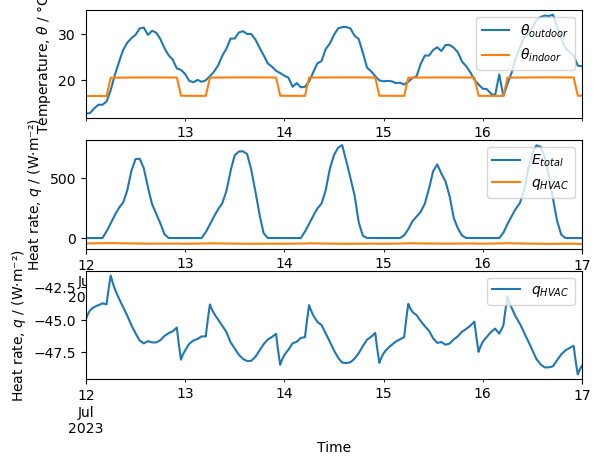

In [57]:
fig, axs = plt.subplots(3, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')

data[[ 'q_HVAC']].plot(ax=axs[2],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[2].set(xlabel='Time')
axs[2].legend([ '$q_{HVAC}$'],
              loc='upper right')
plt.show();

> Figure 2. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

### Plots using matplotlib

Alternativelly, we may use `matplotlib`.

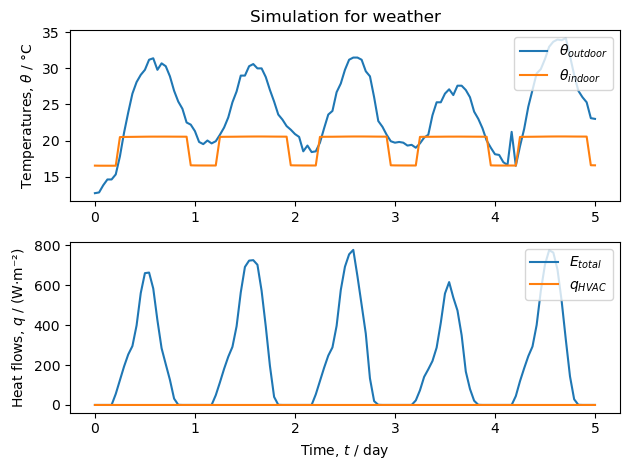

In [14]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y.values, label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Etot'], label='$E_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / (W·m⁻²)')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 3. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion
### Numerical integration method

While fixed-step methods like Euler explicit or implicit integration can be simpler to implement and understand, they may not be the most efficient choice. Variable time step methods offer greater adaptability and efficiency, making them preferable for many simulation scenarios.

Let's compare the simulation time by using Euler explicit and variable time step used in [Python Control Systems Library](https://python-control.readthedocs.io/en/latest/generated/control.input_output_response.html).

The use of Euler numerical integration method is justified when the input vector varies during the numerical integration and changes are done in the _for loop_.

In [15]:
sys = ctrl.ss(As, Bs, Cs, Ds)

θ0 = 20.0 * np.ones(As.shape[0])  # °C, initial temperatures

The convention used by [Python Control Systems Library](https://python-control.readthedocs.io/en/latest/conventions.html) for time series is different from the convention used in Pandas and scipy.signal library: columns represent different points in time, rows are different components (e.g., inputs, outputs or states). Since _dm4bem_ uses Pandas, the vector of inputs in time must be transposed.

In [16]:
u_np = u.values.T       # inputs in time

In [17]:
start_time = time.time()

# Simulate the system response with Python Control Systems Library
t, yout = ctrl.input_output_response(sys, T=t, U=u_np, X0=θ0)

end_time = time.time()
duration_1 = end_time - start_time

In [18]:
start_time = time.time()

# Euler explicit
for k in range(u.shape[0] - 1):
    θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
y = (Cs @ θ.T + Ds @  u.T).T

end_time = time.time()
duration_2 = end_time - start_time

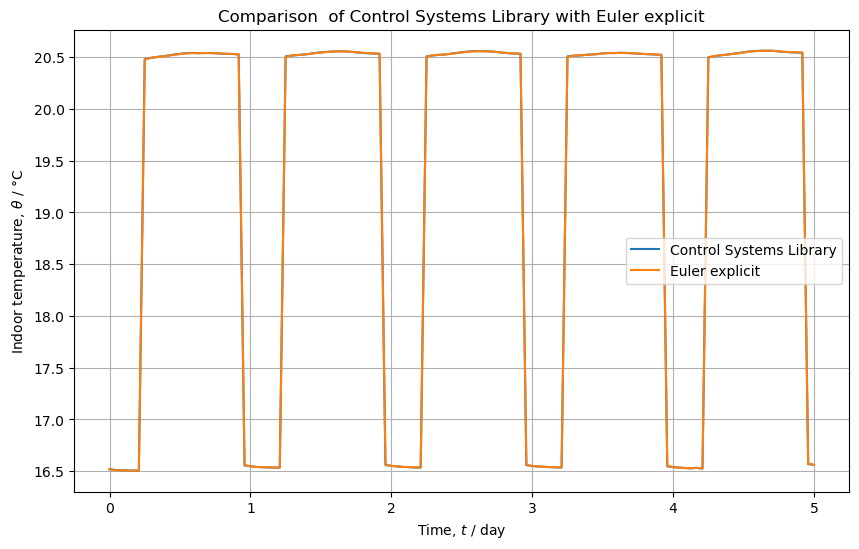

In [19]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.plot(t / 3600 / 24, yout[0], label='Control Systems Library')
axs.plot(t / 3600 / 24, y.values, label='Euler explicit')

axs.set(xlabel='Time, $t$ / day',
        ylabel='Indoor temperature, $θ$ / °C',
        title='Comparison  of Control Systems Library with Euler explicit')
axs.grid(True)
axs.legend()
plt.show()

> Figure 4. Time variation of indoor temperature obtained with Control Systems Library and for-loop Euler.

In [20]:
# Print the comparison of durations
print(f"Duration for Control Systems Library: {duration_1:.2f} seconds")
print(f"Duration for 'Euler explict:          {duration_2:.2f} seconds")

Duration for Control Systems Library: 0.05 seconds
Duration for 'Euler explict:          0.25 seconds


### Controller influence on time step

Simulate the system without controller (i.e., in free floating) and with controller.

Note that the time step for Euler explicit method depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$) when $K_p  \approx 10^3 \ \mathrm{W/K}$. Change $K_p  \approx 10^2 \ \mathrm{W/K}$ and $K_p  \approx 10^4 \ \mathrm{W/K}.$

## References

1. [C. Ghiaus (2013)](https://doi.org/10.1016/j.energy.2012.10.024). Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, , open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. [C. Ghiaus (2021)](https://doi.org/10.1007/978-3-030-76477-7_5). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198, open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. [J.A. Duffie, W. A. Beckman, N. Blair (2020)](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf). Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html). Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

6. [J.R. Howell et al. (2021)](http://www.thermalradiation.net/indexCat.html). Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, A Catalogue of Configuration Factors

7. [J. Widén, J. Munkhammar (2019)](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf). Solar Radiation Theory, Uppsala University